In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Geometry generation

In [2]:
R = 1. # cm
pitch = 3.6 #cm 
yoffset_plane = 1.6
yoffset_layer = 1.3
zshift_layer = 1.9
zshift_plane = 4.2

In [80]:
class Tracker(object):
    
    def __init__(self, R, pitch, yoffset_plane, yoffset_layer, zshift_layer, zshift_plane):
        
        self.R = R
        self.pitch = pitch
        self.yoffset_plane = yoffset_plane
        self.yoffset_layer = yoffset_layer
        self.zshift_layer = zshift_layer
        self.zshift_plane = zshift_plane
        
        
    def create_geometry(self):
        
        base = np.arange(-100, 101, 1)
        step = self.pitch
        
        layer1_y = step * base
        layer1_z = 0. * np.ones(len(base))
        
        layer2_y = layer1_y + self.yoffset_layer
        layer2_z = layer1_z + self.zshift_layer
        
        layer3_y = layer1_y + self.yoffset_plane
        layer3_z = layer1_z + self.zshift_plane
        
        layer4_y = layer3_y + self.yoffset_layer
        layer4_z = layer3_z + self.zshift_layer
        
        Z = np.concatenate((layer1_z.reshape(-1, 1), 
                            layer2_z.reshape(-1, 1), 
                            layer3_z.reshape(-1, 1), 
                            layer4_z.reshape(-1, 1)), axis=1)
        
        Y = np.concatenate((layer1_y.reshape(-1, 1), 
                            layer2_y.reshape(-1, 1), 
                            layer3_y.reshape(-1, 1), 
                            layer4_y.reshape(-1, 1)), axis=1)
        
        geo = [Z, Y]
        
        return geo
    

In [81]:
tr = Tracker(R, pitch, yoffset_plane, yoffset_layer, zshift_layer, zshift_plane)
geo = tr.create_geometry()

In [82]:
Z, Y = geo

### Geometry display

In [83]:
def geometry_display(Z, Y, y_min=-10, y_max=10):

    Z_flat = np.ravel(Z)
    Y_flat = np.ravel(Y)

    z_min = Z_flat.min()
    z_max = Z_flat.max()

    sel = (Y_flat >= y_min) * (Y_flat < y_max)
    Z_flat = Z_flat[sel]
    Y_flat = Y_flat[sel]

    plt.figure(figsize=(6, 6 * (y_max - y_min + 2) / (z_max - z_min + 10)))
    plt.scatter(Z_flat, Y_flat)

    for z,y in zip(Z_flat, Y_flat):

        circle = plt.Circle((z, y), 1., color='b', fill=False)
        plt.gcf().gca().add_artist(circle)



    plt.xlim(z_min - 5, z_max + 5)
    plt.ylim(y_min - 1, y_max + 1)
    #plt.show()

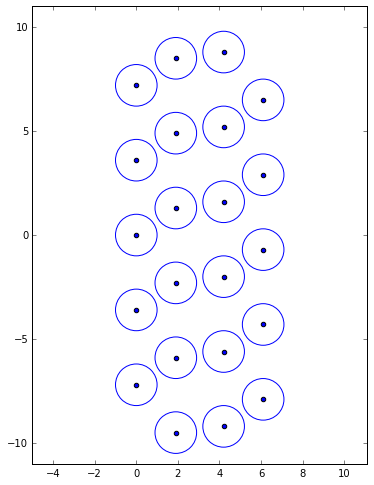

In [84]:
geometry_display(Z, Y, y_min=-10, y_max=10)

### Tracks generation

In [85]:
class Tracks(object):
    
    def __init__(self, b_min, b_max, angle_mean, angle_std):
        
        self.b_min = b_min
        self.b_max = b_max
        self.angle_mean = angle_mean
        self.angle_std = angle_std
        
    def generate(self, N):
        
        B = np.random.RandomState(42).uniform(self.b_min, self.b_max, N)
        Angles = np.random.RandomState(42).normal(self.angle_mean, self.angle_std, N)
        K = np.tan(Angles)
        
        tracks = np.concatenate((K.reshape(-1, 1), B.reshape(-1, 1)), axis=1)
        
        return tracks

In [122]:
t = Tracks(-100, 100, 0, 0.2)
tracks = t.generate(1000)

### Tracks display

In [123]:
def tracks_display(tracks, Z):

    Z_flat = np.ravel(Z)

    z_min = Z_flat.min()
    z_max = Z_flat.max()
    
    z1 = z_min - 5
    z2 = z_max + 5

    for k, b in tracks:
        
        plt.plot([z1, z2], [k * z1 + b, k * z2 + b], c='0.2')



    #plt.show()

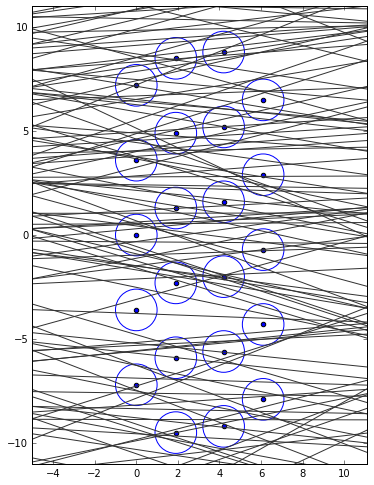

In [124]:
geometry_display(Z, Y, y_min=-10, y_max=10)
tracks_display(tracks, Z)

### Metric

In [125]:
def score(Z, Y, tracks, R):
    
    values = []
    
    for k, b in tracks:
        
        Y_pred = k * Z + b
        dY = np.abs(Y_pred - Y)
        
        alpha = np.arctan(k)
        cos = np.cos(alpha)
        
        is_intersect = dY * cos < R
        n_intersections = (is_intersect).sum()
        
        if n_intersections >= 2:
            values.append(1)
        else:
            values.append(0)
    
    
    return np.mean(values)

In [126]:
print score(Z, Y, tracks, R)

0.878
